## Setup

In [1]:
GLOBAL_SEED = 42

import os
os.environ['PYTHONHASHSEED'] = str(GLOBAL_SEED)
import sys

import gc
from tqdm import tqdm
import datetime
import pickle
import random as rnd
from glob import glob
import pandas as pd
import numpy as np
from numpy import random as np_rnd
import warnings
from math import ceil

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from itertools import combinations
from collections import Counter

import lightgbm as lgb
import xgboost as xgb
import catboost as cat

import optuna
from optuna import Trial, create_study
from optuna.samplers import TPESampler

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer 
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from mpl_toolkits import mplot3d
from matplotlib.colors import ListedColormap
from sklearn.neighbors import LocalOutlierFactor

from sklearn.impute import KNNImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from itertools import product
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from scipy.stats import f_oneway
from scipy.stats import pearsonr

# display setting
warnings.filterwarnings(action='ignore')
rcParams['axes.unicode_minus'] = False

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # python random
    rnd.seed(seed)
    # numpy random
    np_rnd.seed(seed)
    # tf random
    try:
        tf_rnd.set_seed(seed)
    except:
        pass
    # RAPIDS random
    try:
        cupy.random.seed(seed)
    except:
        pass
    # pytorch random
    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    except:
        pass

def pickleIO(obj, src, op="w"):
    if op=="w":
        with open(src, op + "b") as f:
            pickle.dump(obj, f)
    elif op=="r":
        with open(src, op + "b") as f:
            tmp = pickle.load(f)
        return tmp
    else:
        print("unknown operation")
        return obj

def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]

def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)
        
def week_of_month(dt):
    """ 
        Returns the week of the month for the specified date.
    """
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + (1 + first_day.weekday()) % 7
    return int(ceil(adjusted_dom/7.0))

def quality_to_class(x, threshold):
    y_pred_class = []
    for i in x:
        tmp_class = len(threshold)
        for k, v in threshold.items():
            if i < v:
                tmp_class = k
                break
        y_pred_class.append(tmp_class)
    return y_pred_class

In [3]:
class CFG:
    debug = False
    TF = True
    product_mapper = {
        "A": ["T010305", "T010306", "T050304", "T050307"],
        "O": ["T100304", "T100306"],
        "T": ["T100304", "T100306"],
    }
    line_mapper = {
        "T010305": "A", "T010306": "A", "T050304": "A", "T050307": "A",
        "T100304": "O_T", "T100306": "O_T",
    }
    line_groups = [
        ["T010305", "T010306"],
        ["T050304", "T050307"],
        ["T100304", "T100306"],
    ]
    classes = [0, 1, 2]
    time_features = ["month", "day", "weekday", "week_of_month", "hour", "office_hour", "sec_in_day", "sin_in_day", "cos_in_day"]

In [4]:
quality_threshold = pickleIO(None, "../datasets/dataset_valid/quality_threshold.pkl", "r")
quality_threshold['T010305_T010306_T050304_T050307'] = {0: (0.525046 + 0.525086) / 2, 1: (0.534843 + 0.535279) / 2}

In [5]:
quality_threshold = {
    "T010305_T010306": {0: 0.52507, 1: 0.53490},
    "T050304_T050307": {0: 0.52507, 1: 0.53490},
    "T100304_T100306": {0: 0.52507, 1: 0.53490},
}

In [6]:
quality_threshold

{'T010305_T010306': {0: 0.52507, 1: 0.5349},
 'T050304_T050307': {0: 0.52507, 1: 0.5349},
 'T100304_T100306': {0: 0.52507, 1: 0.5349}}

## Loading Data

In [7]:
# information Provided by Dacon

# PRODUCT_ID : 제품의 고유 ID
# Y_Class : 제품 품질 상태(Target) 
# 0 : 적정 기준 미달 (부적합)
# 1 : 적합
# 2 : 적정 기준 초과 (부적합)
# Y_Quality : 제품 품질 관련 정량적 수치
# TIMESTAMP : 제품이 공정에 들어간 시각
# LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
# PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
# X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [8]:
df_full = pd.read_csv("../datasets/train.csv")
df_full.columns = df_full.columns.str.lower()

In [9]:
# time feature engineernig
df_full["timestamp"] = pd.to_datetime(df_full["timestamp"])
df_full["month"] = df_full["timestamp"].dt.month
df_full["day"] = df_full["timestamp"].dt.day
df_full["weekday"] = df_full["timestamp"].dt.weekday
df_full["week_of_month"] = df_full["timestamp"].apply(week_of_month)
df_full["hour"] = df_full["timestamp"].dt.hour
df_full["office_hour"] = df_full["hour"].apply(lambda x: 1 if ((x >= 9) & (x < 18)) else 0)
df_full["sec_in_day"] = (df_full["timestamp"] - df_full["timestamp"].dt.normalize()).dt.total_seconds() / 3600
df_full["sin_in_day"] = np.sin(2 * np.pi * df_full["sec_in_day"].values)
df_full["cos_in_day"] = np.cos(2 * np.pi * df_full["sec_in_day"].values)

In [10]:
# df_train = pickleIO(None, "../../datasets/dataset_valid2/df_train.pkl", "r")
# df_valid = pickleIO(None, "../../datasets/dataset_valid2/df_valid.pkl", "r")

In [11]:
# # time feature engineernig
# df_train["month"] = df_train["timestamp"].dt.month
# df_train["day"] = df_train["timestamp"].dt.day
# df_train["weekday"] = df_train["timestamp"].dt.weekday
# df_train["week_of_month"] = df_train["timestamp"].apply(week_of_month)
# df_train["hour"] = df_train["timestamp"].dt.hour
# df_train["office_hour"] = df_train["hour"].apply(lambda x: 1 if ((x >= 9) & (x < 18)) else 0)
# df_train["sec_in_day"] = (df_train["timestamp"] - df_train["timestamp"].dt.normalize()).dt.total_seconds() / 3600
# df_train["sin_in_day"] = np.sin(2 * np.pi * df_train["sec_in_day"].values)
# df_train["cos_in_day"] = np.cos(2 * np.pi * df_train["sec_in_day"].values)

In [12]:
# # time feature engineernig
# df_valid["month"] = df_valid["timestamp"].dt.month
# df_valid["day"] = df_valid["timestamp"].dt.day
# df_valid["weekday"] = df_valid["timestamp"].dt.weekday
# df_valid["week_of_month"] = df_valid["timestamp"].apply(week_of_month)
# df_valid["hour"] = df_valid["timestamp"].dt.hour
# df_valid["office_hour"] = df_valid["hour"].apply(lambda x: 1 if ((x >= 9) & (x < 18)) else 0)
# df_valid["sec_in_day"] = (df_valid["timestamp"] - df_valid["timestamp"].dt.normalize()).dt.total_seconds() / 3600
# df_valid["sin_in_day"] = np.sin(2 * np.pi * df_valid["sec_in_day"].values)
# df_valid["cos_in_day"] = np.cos(2 * np.pi * df_valid["sec_in_day"].values)

In [13]:
# df_train.info()

In [14]:
# df_train.head()

In [15]:
# df_train["y_quality"]

In [16]:
# df_train.groupby(["line", "product_code"]).size()

In [17]:
# df_valid.info()

In [18]:
# df_valid.head()

In [19]:
# df_valid["y_quality"]

In [20]:
# df_valid.groupby(["line", "product_code"]).size()

In [21]:
df_full["tmp"] = df_full["product_code"].apply(lambda x: 1 if x == "A_31" else 0)
display(df_full.groupby(["tmp", "y_class"])["y_quality"].describe().T)
df_full = df_full.drop("tmp", axis=1)

tmp              0                                 1                       
y_class          0           1          2          0           1          2
count    28.000000  289.000000  32.000000  60.000000  118.000000  71.000000
mean      0.521246    0.530272   0.538753   0.520646    0.530209   0.543508
std       0.005765    0.002334   0.004931   0.003990    0.002705   0.008733
min       0.502517    0.525213   0.534951   0.500856    0.525086   0.535279
25%       0.520467    0.528483   0.535541   0.519388    0.527989   0.537330
50%       0.523422    0.530308   0.536237   0.521315    0.530353   0.539235
75%       0.524612    0.532119   0.539517   0.523522    0.532332   0.547506
max       0.525067    0.534837   0.551279   0.525046    0.534843   0.578841

In [22]:
df_full["tmp"] = df_full["product_code"].apply(lambda x: 1 if x == "A_31" else 0)
display(df_full.groupby("tmp")["y_class"].describe().T)
df_full = df_full.drop("tmp", axis=1)

tmp,0,1
count,349.000000,249.000000
mean,1.011461,1.044177
std,0.415069,0.725442
min,0.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,2.000000
max,2.000000,2.000000


In [23]:
df_full["tmp"] = df_full["product_code"].apply(lambda x: 1 if x == "A_31" else 0)
print(df_full.groupby("tmp")["y_class"].value_counts(normalize=True))
df_full = df_full.drop("tmp", axis=1)

tmp  y_class
0    1          0.828080
     2          0.091691
     0          0.080229
1    1          0.473896
     2          0.285141
     0          0.240964
Name: y_class, dtype: float64


In [24]:
df_test = pd.read_csv("../datasets/test.csv")
df_test.columns = df_test.columns.str.lower()

In [25]:
# time feature engineernig
df_test["timestamp"] = pd.to_datetime(df_test["timestamp"])
df_test["month"] = df_test["timestamp"].dt.month
df_test["day"] = df_test["timestamp"].dt.day
df_test["weekday"] = df_test["timestamp"].dt.weekday
df_test["week_of_month"] = df_test["timestamp"].apply(week_of_month)
df_test["hour"] = df_test["timestamp"].dt.hour
df_test["office_hour"] = df_test["hour"].apply(lambda x: 1 if ((x >= 9) & (x < 18)) else 0)
df_test["sec_in_day"] = (df_test["timestamp"] - df_test["timestamp"].dt.normalize()).dt.total_seconds() / 3600
df_test["sin_in_day"] = np.sin(2 * np.pi * df_test["sec_in_day"].values)
df_test["cos_in_day"] = np.cos(2 * np.pi * df_test["sec_in_day"].values)

In [26]:
df_test.head()

,product_id,timestamp,line,product_code,x_1,x_2,x_3,x_4,x_5,x_6,...,x_2875,month,day,weekday,week_of_month,hour,office_hour,sec_in_day,sin_in_day,cos_in_day
0,TEST_000,2022-09-09 02:01:00,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,9,9,4,2,2,0,2.016667,0.104528,0.994522
1,TEST_001,2022-09-09 02:09:00,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,9,9,4,2,2,0,2.150000,0.809017,0.587785
2,TEST_002,2022-09-09 08:42:00,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,9,9,4,2,8,0,8.700000,-0.951057,-0.309017
3,TEST_003,2022-09-09 10:56:00,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9,9,4,2,10,1,10.933333,-0.406737,0.913545
4,TEST_004,2022-09-09 11:04:00,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9,9,4,2,11,1,11.066667,0.406737,0.913545


## Training by Lines

* "T010305", "T010306"
* "T050304", "T050307"
* "T100304", "T100306"

In [27]:
architecture_root_path = "./architectures/"
architecture_name = "daheeRef_pca_linear_metaLearning_try1"
architecture_path = architecture_root_path + architecture_name + "/"
createFolder(architecture_path)

In [28]:
# Shuffling
df_full = df_full.sample(frac=1, random_state=GLOBAL_SEED).reset_index(drop=True)

In [29]:
# Label Encoding on Line
lbe = LabelEncoder()
lbe.fit(["T010305", "T010306", "T050304", "T050307", "T100304", "T100306"])

LabelEncoder()

In [30]:
df_meta = {"reg_qual": None, "cls_cls": None, "reg_cls": None}

### Training - Regression (y_quality) 

In [31]:
# optuna function
def optuna_objective_function(trial: Trial, fold, train_x, train_y, train_weight, val_x, val_y, val_weight, output_container):

    tuning_params = {
        "alpha": trial.suggest_categorical("alpha", list(np.linspace(1e-3, 1.0, num=150, endpoint=False)) + list(np.linspace(1.0, 1e+2, num=50, endpoint=False))),
        "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0, step=0.01),
    }

    model = lm.ElasticNet(random_state=fold, **tuning_params)
    
    model.fit(train_x, train_y)
    
    pred = model.predict(val_x)
    
#     y_true = np.expm1(val_y) if CFG.TF else val_y
#     y_pred = np.expm1(pred) if CFG.TF else pred
    
    y_true = val_y
    y_pred = pred
    
    optuna_score = mean_squared_error(y_true, y_pred, squared=False)
    
    if optuna_score < output_container["optuna_score"]:
        output_container["model"] = model
        output_container["pred"] = pred
        output_container["optuna_score"] = optuna_score

    return optuna_score

import operator
class Optuna_EarlyStoppingCallback(object):
    """Early stopping callback for Optuna."""

    def __init__(self, early_stopping_rounds: int, direction: str = "minimize") -> None:
        self.early_stopping_rounds = early_stopping_rounds

        self._iter = 0

        if direction == "minimize":
            self._operator = operator.lt
            self._score = np.inf
        elif direction == "maximize":
            self._operator = operator.gt
            self._score = -np.inf
        else:
            ValueError(f"invalid direction: {direction}")

    def __call__(self, study: optuna.Study, trial: optuna.Trial) -> None:
        """Do early stopping."""
        if self._operator(study.best_value, self._score):
            self._iter = 0
            self._score = study.best_value
        else:
            self._iter += 1

        if self._iter >= self.early_stopping_rounds:
            study.stop()

## EDA wih PCA reduction

(249, 515)
(249, 515)
4
(245, 41)
(67, 41)


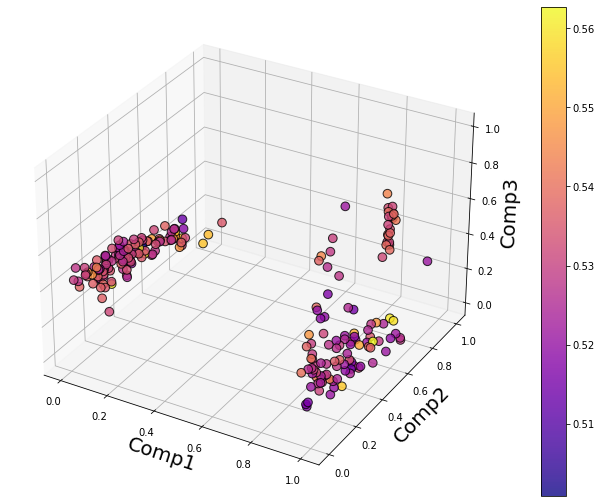

(349, 441)
(349, 441)
2
(347, 101)
(243, 101)


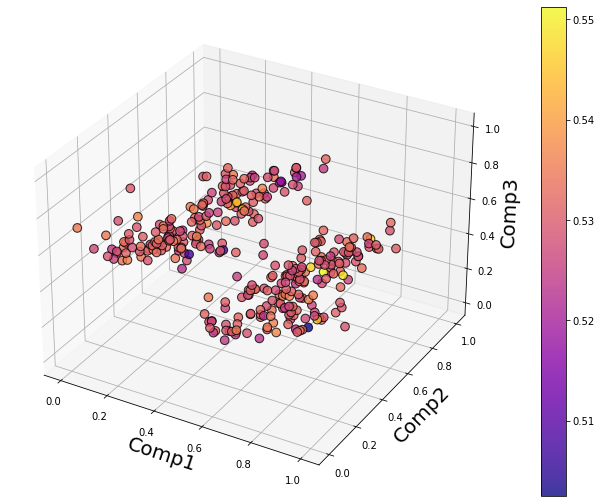

In [33]:
line_split = [
    # A
    ["A_31"],
    # O, T
    ["T_31", "O_31"],
]

for line in line_split:
    seed_everything()
    
    # Training
    # === Preprocessing (Train) ===
    full_x = df_full[df_full["product_code"].isin(line)]
    full_x["line"] = lbe.transform(full_x["line"])
    
    full_y = full_x["y_quality"].values
    full_y_cls = full_x["y_class"].values
    
    # Drop columns
    full_x = full_x.drop(["product_id", "y_class", "y_quality", "timestamp", "product_code"], axis=1)
    full_x = full_x[full_x.columns[~(full_x.var() == 0).values & ~full_x.isna().all().values]]
    # Get nan values is less than 0.2
    full_x = full_x[full_x.columns[full_x.isna().sum() < (len(full_x) * 0.2)]]
    
#     break
    full_x = full_x.apply(lambda x: x.fillna(x.mean()), axis=1)
#     break
    
    full_x = full_x.T.drop_duplicates().T
#     full_x = full_x.drop_duplicates().reset_index(drop=True)
#     break
    
    
    selected_vars = full_x.columns
    cat_vars = ["line"]
    num_vars = diff(selected_vars, cat_vars)
    categoIdx = findIdx(selected_vars, cat_vars)

    full_x[num_vars] = full_x[num_vars].astype("float32")
    full_x[cat_vars] = full_x[cat_vars].astype("int32")
    print(full_x.shape)

#     poly_fe = PolynomialFeatures(2)
#     full_x = poly_fe.fit_transform(full_x)
#     full_x[["squared_" + str(i) for i in num_vars]] = (full_x[num_vars] ** 2).values
#     full_x[["cubic_" + str(i) for i in num_vars]] = (full_x[num_vars] ** 3).values
#     break
    pft = PowerTransformer()
    full_x = pft.fit_transform(full_x)
    
    # Scaling
    scaler = StandardScaler()
    full_x = scaler.fit_transform(full_x)
    print(full_x.shape)
    # Remove outliners
    out_cls = LocalOutlierFactor(n_neighbors=5)
    out_liers = out_cls.fit_predict(full_x)
    tmp_cls = full_y_cls[out_liers == -1]
    n_outliers = (out_liers == -1).sum()
    print(n_outliers)
    full_y_cls = full_y_cls[out_liers == 1]
    full_y = full_y[out_liers == 1]
    full_x = full_x[out_liers == 1]
    
#     break
    # PCA
    pca = PCA(128)
    pca.fit(full_x)
    n_comp = np.where(pca.explained_variance_ratio_.cumsum() > 0.9)[0]
    n_comp = 64 if len(n_comp) == 0 else (n_comp[0] + 1)
    full_x = pca.transform(full_x)[:, :n_comp]
    print(full_x.shape)
#     break
    
    # === Preprocessing (Test) ===
    test_x = df_test[df_test["product_code"].isin(line)]
    test_x["line"] = lbe.transform(test_x["line"])
    test_x = test_x[selected_vars]
    test_x = test_x.fillna(-1.0)
    
    test_x[num_vars] = test_x[num_vars].astype("float32")
    test_x[cat_vars] = test_x[cat_vars].astype("int32")
    
#     test_x = poly_fe.transform(test_x)
#     test_x[["squared_" + str(i) for i in num_vars]] = (test_x[num_vars] ** 2).values
#     test_x[["cubic_" + str(i) for i in num_vars]] = (test_x[num_vars] ** 3).values
    
    test_x = pft.transform(test_x)
    
    # Scaling
    test_x = scaler.transform(test_x)
#     break

    # PCA
    test_x = pca.transform(test_x)[:, :n_comp]
    print(test_x.shape)

    # EDA
    viz_df = full_x[:, [0,1,2]]
    viz_df = MinMaxScaler().fit_transform(viz_df)

    fig = plt.figure(figsize=(16, 9))
    ax = plt.axes(projection='3d')

    # Data for three-dimensional scattered points
    xdata = viz_df[:, 0]
    ydata = viz_df[:, 1]
    zdata = viz_df[:, 2]
    points = ax.scatter3D(xdata[full_y < 0.57], ydata[full_y < 0.57], zdata[full_y < 0.57], c=full_y[full_y < 0.57], marker = 'o', cmap="plasma", alpha=0.8, s=75, edgecolor='k')

    # points = ax.scatter(x, y, c=z, s=50, cmap="plasma")
    fig.colorbar(points)

    ax.set_xlabel('Comp1', fontsize=20, rotation=150)
    ax.set_ylabel('Comp2', fontsize=20, rotation=150)
    ax.set_zlabel('Comp3', fontsize=20, rotation=150)
    
    plt.show()